In [1]:
#Training the model on the Common Voice Dataset Training Split

In [2]:
#Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing for csv files
import matplotlib.pyplot as plt # visualizing data
import seaborn as sns # visualizing data2
import sklearn # contain algorithms
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import plotly.graph_objects as go
from scipy.io import wavfile
from tempfile import mktemp
from pydub import AudioSegment
import IPython
import librosa
import IPython.display as ipd
import librosa.display
plt.figure(figsize=(15,4))
#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, LSTM, Dropout
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#from sklearn.model_selection import RepeatedStratifiedKFold

ModuleNotFoundError: No module named 'pydub'

In [ ]:
## PART 1: Understanding Data

#importing the valid training data
df =  pd.read_csv("/media/amina/DISQDURLHM/AMINA/PFE24/datasets/commonvoice/cv-valid-train.csv")
df[df['age'].notna()].shape

(73768, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195776 entries, 0 to 195775
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   filename    195776 non-null  object 
 1   text        195776 non-null  object 
 2   up_votes    195776 non-null  int64  
 3   down_votes  195776 non-null  int64  
 4   age         73768 non-null   object 
 5   gender      74059 non-null   object 
 6   accent      64711 non-null   object 
 7   duration    0 non-null       float64
dtypes: float64(1), int64(2), object(5)
memory usage: 11.9+ MB


<Axes: xlabel='age', ylabel='count'>

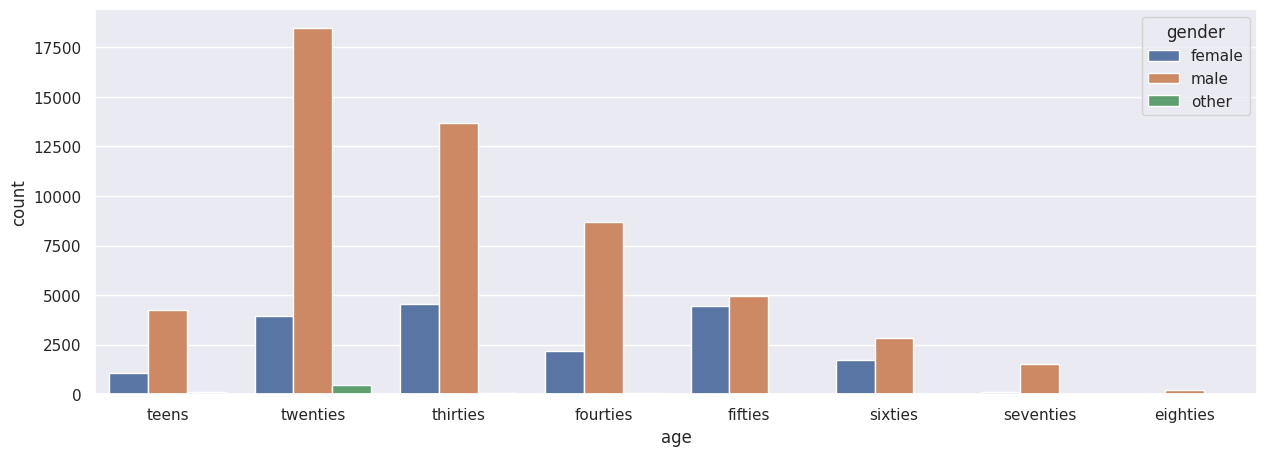

In [ ]:
#Seeing the gender to age distribution in the dataset samples.
sns.countplot(x="age", 
        hue='gender',
        data=df[df['age'].notna()],
        order=['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties']
        )

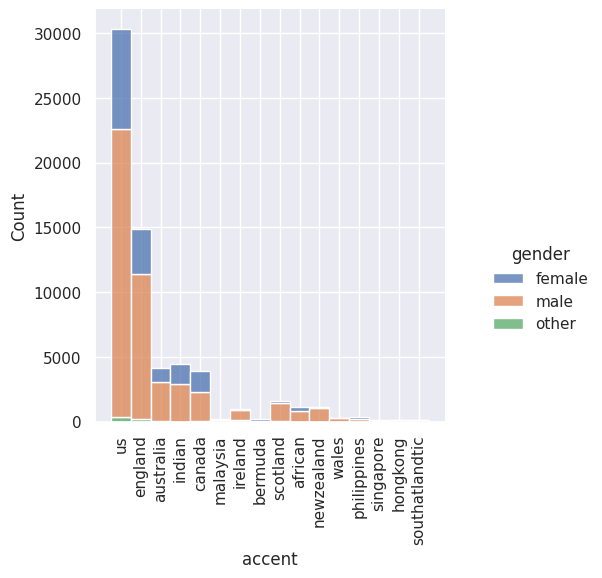

In [ ]:
#Seeing the gender to age distribution in relation to accent (country)
p = sns.displot(x="accent", 
        data=df[df['accent'].notna()], 
        hue='gender',
        multiple='stack')
p.set_xticklabels(rotation=90)
plt.show()

initial: (195776, 8) final: (63163, 8)


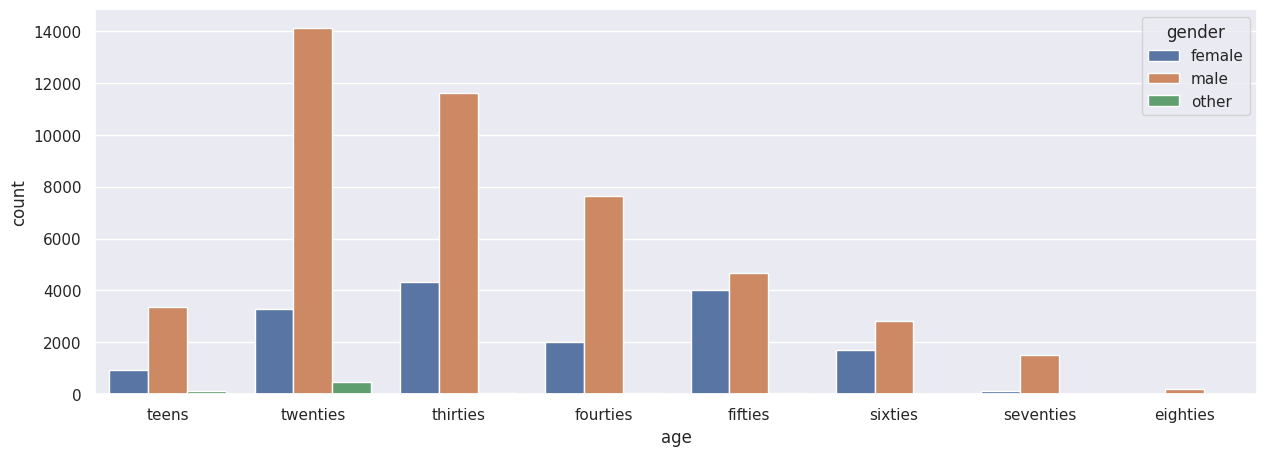

In [ ]:
# Deleting missing values from the columns 'age', 'gender', and 'accent'
st=df.shape
en = df[df['age'].notna()& df['gender'].notna() & df['accent'].notna()].shape
print("initial: {} final: {}".format(st, en))
sns.countplot(x="age", 
        hue='gender',
        data=df[df['age'].notna()& df['gender'].notna() & df['accent'].notna()],
        order=['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties'])
plt.show()

In [ ]:
##PART2: Data Cleaning

#we extract the columns that we think useful are
df = df[['filename','age','gender']]
#To clean the data we remove the sample with NaN attribute values.
unbalanced_data = df[df['age'].notna() & df['gender'].notna()]
unbalanced_data.reset_index(inplace=True, drop=True)
unbalanced_data.head(3)

,filename,age,gender
0,cv-valid-train/sample-000005.mp3,twenties,female
1,cv-valid-train/sample-000008.mp3,seventies,male
2,cv-valid-train/sample-000013.mp3,thirties,female


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31455 entries, 0 to 31454
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  31455 non-null  object
 1   age       31455 non-null  object
 2   gender    31455 non-null  object
dtypes: object(3)
memory usage: 737.4+ KB
None


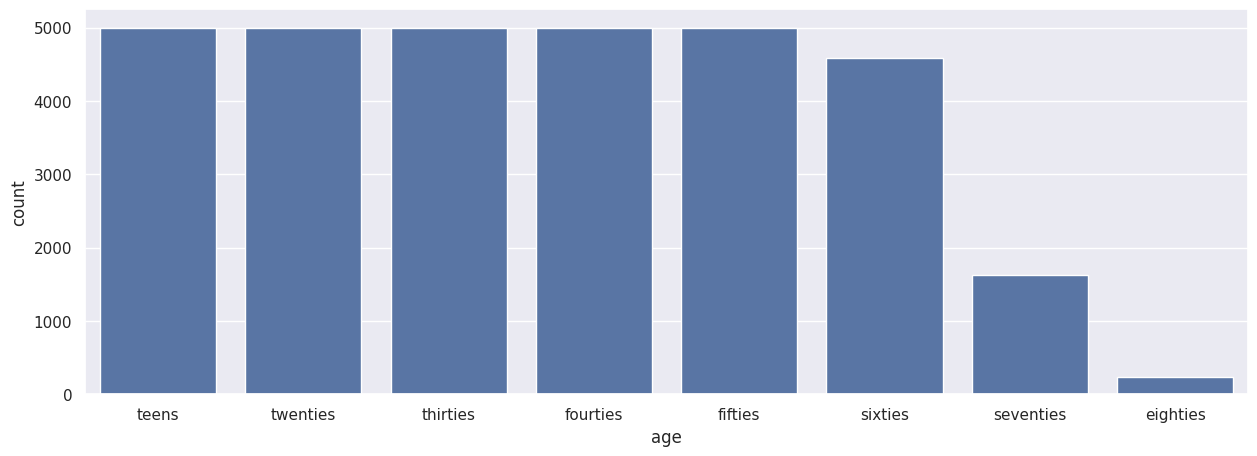

In [ ]:
#Balancing data

#Make it so there are 5000 datapoints of each age range. 
#This leads to there being less datapoints in the 70s/80s range
grouped = unbalanced_data.groupby("age")
grouped.groups.values()
frames_of_groups = [x.sample(min(len(x), 5000)) for y, x in grouped]
new_df = pd.concat(frames_of_groups)
new_df.reset_index(drop=True, inplace=True)

sns.set(rc={'figure.figsize':(15, 5)})
sns.countplot(x="age", 
        data=new_df, 
        order=['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties'])

print(new_df.info())
plt.savefig('balanced_age_exploration.png')
plt.show()

In [ ]:
cleanup_nums = {"age": {"teens":1.0,"twenties":2.0,"thirties":3.0,"fourties":4.0,"fifties":5.0,"sixties":6.0,"seventies":7.0,"eighties":8.0}}
data = new_df.replace(cleanup_nums)
data.head()

,filename,age,gender
0,cv-valid-train/sample-029101.mp3,8.0,male
1,cv-valid-train/sample-067913.mp3,8.0,female
2,cv-valid-train/sample-187374.mp3,8.0,male
3,cv-valid-train/sample-081802.mp3,8.0,male
4,cv-valid-train/sample-162602.mp3,8.0,male


In [ ]:
##PART 3: Feature Extraction
ds_path = "/media/amina/DISQDURLHM/AMINA/PFE24/datasets/commonvoice/cv-valid-train/"

#this function is used to extract audio frequency features
def feature_extraction(filename, sampling_rate=48000):
    path = "{}{}".format(ds_path, filename)
    features = list()
    audio, _ = librosa.load(path, sr=sampling_rate)
    
    gender = data[data['filename'] == filename].gender.values[0]
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))
    features.append(gender)
    features.append(spectral_centroid)
    features.append(spectral_bandwidth)
    features.append(spectral_rolloff)
    
    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate)
    for el in mfcc:
        features.append(np.mean(el))
    
    return features
    
        
features = feature_extraction(data.iloc[0]['filename'])
print("features: ", features)
#we will be working with a CNN or RNN or a hybrid of the two architecture
#that extract features internally.

features:  ['male', 1841.3683577619906, 1412.9345411339955, 3106.7095588235293, -382.291, 119.56899, -13.154488, 21.510107, 14.874688, -22.165981, 1.2866997, -1.876408, -19.085619, -5.590872, -4.8857107, -4.4170766, 2.7138138, -5.7046924, -4.6493926, 0.51919854, -6.625859, -3.807832, 0.42300093, -4.6487556]


In [ ]:
#the function create dataframe to store the feature and label related to each other
def create_df_features(orig):
    new_rows = list()
    tot_rows = len(orig)-1
    stop_counter = 55001
    
    for idx, row in orig.iterrows():
        if idx >= stop_counter: break
        print("\r", end="")
        print("{}/{}".format(idx, tot_rows), end="", flush=True)
        features = feature_extraction(row['filename'])
        features.append(row['age'])
        new_rows.append(features)
    return pd.DataFrame(new_rows, columns=["label", "spectral_centroid", "spectral_bandwidth", "spectral_rolloff",
                                    "mfcc1", "mfcc2", "mfcc3", "mfcc4", "mfcc5", "mfcc6", "mfcc7", "mfcc8",
                                   "mfcc9", "mfcc10", "mfcc11", "mfcc12", "mfcc13", "mfcc14", "mfcc15", "mfcc16",
                                   "mfcc17", "mfcc18", "mfcc19", "mfcc20", "age"])

#df_features = create_df_features(data) # uncomment if running for the first time

31454/31454

In [ ]:
#df_features.to_csv('/home/amina/PFE/app/df_features.csv', index=False) # to save to disk
#df_features = pd.read_csv('/home/amina/PFE/app/df_features.csv')
df_features = pd.read_csv("C:\Users\DrdrA\OneDrive\Desktop\UNI\M2\PFE\app\df_features.csv")
df_features.head()


,label,spectral_centroid,spectral_bandwidth,spectral_rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,age
0,male,1841.368358,1412.934541,3106.709559,-382.290985,119.568993,-13.154488,21.510107,14.874688,-22.165981,...,-4.417077,2.713814,-5.704692,-4.649393,0.519199,-6.625859,-3.807832,0.423001,-4.648756,8.0
1,female,3298.149214,2609.785114,5770.386708,-357.509979,102.530609,-23.735870,18.985992,-7.268692,7.222281,...,-8.769171,-6.161270,-9.853709,-10.822701,-1.504161,-0.243809,-3.442723,-8.855586,-5.309559,8.0
2,male,3269.878415,3275.167166,6478.420017,-344.118195,117.586647,-10.352144,55.782391,-0.865676,27.381851,...,-9.068440,2.439638,-5.864700,-0.971397,-0.503343,-1.558824,2.357886,-2.554007,1.507503,8.0
3,male,1818.272348,1730.343876,3394.077035,-426.101379,84.500443,7.808618,15.364682,12.722142,-4.012818,...,-7.115186,-4.762973,0.024635,-1.670767,-7.556617,-8.335911,-2.311363,-2.929997,-7.212907,8.0
4,male,2392.383913,2578.192255,4415.226064,-270.626038,150.563416,6.450707,43.648205,-3.889018,14.087127,...,-9.347455,1.287844,-4.402797,-1.326470,1.118305,-3.790538,1.328930,-1.596439,-0.110682,8.0


In [ ]:
#model creation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC

cols = ['label', 'spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff',
       'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8',
       'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
       'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'age']
x_cols = cols[:-1]
y_col = 'age'
categorical_features, numerical_features = [x_cols[:1], x_cols[1:]]

numerical_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

prediction_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", SVC(C=100, gamma='scale'))]
)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_features[x_cols], df_features[y_col], test_size=0.2, random_state=0)
prediction_pipeline.fit(X_train, y_train)

print("model score: %.3f" % prediction_pipeline.score(X_test, y_test))

model score: 0.809
